In [1]:
import glob

import numpy             as np
import matplotlib.pyplot as plt

from CCfun  import filter_df

from CCplot import plot1d
from CCplot import plot2d
from CCplot import plot_line
from CCplot import auto_plot_style
from CCplot import figure_sizes
from CCplot import subplots

from CCdatabase import paper_signals
from CCdatabase import californication_irradiation_mapping

from CCio import load_all
from CCio import merge_measurements

In [2]:
%matplotlib inline

auto_plot_style()

In [3]:
%load_ext autoreload
%autoreload 2

# All data

In [4]:
filenames_pre  = glob.glob("/home/gonzalo/data/CC/Californication/*pre*.h5")
filenames_post = glob.glob("/home/gonzalo/data/CC/Californication/*post*.h5")
experiment     = load_all(filenames_pre, filenames_post)

In [5]:
experiment.pre.crystals.head()

looparound  crystal  grating  exp_index  slit_width  state  exposure  \
0       False        7        2          0        1000    516       0.1   
1       False        7        2          0        1000    516       0.1   
2       False        7        2          0        1000    516       0.1   
3       False        7        2          0        1000    516       0.1   
4       False        7        2          0        1000    516       0.1   

   ex_wl     power   em_wl  counts crystal_id crystal_type  bkgsub   rate  \
0  275.0  0.000008  287.75    3228  Sp_B1_004           Sp   -58.0 -580.0   
1  275.0  0.000008  288.25    3232  Sp_B1_004           Sp   -54.0 -540.0   
2  275.0  0.000008  288.75    3211  Sp_B1_004           Sp   -75.0 -750.0   
3  275.0  0.000008  289.50    3222  Sp_B1_004           Sp   -64.0 -640.0   
4  275.0  0.000008  290.00    3209  Sp_B1_004           Sp   -77.0 -770.0   

        quantar       dquanta  wheel_no  
0  1.104294e+15 -5.252226e-13         0  
1  1.104294e+15 -4.890003e-13         0  
2  1.104294e+15 -6.791671e-13         0  
3  1.104294e+15 -5.795559e-13         0  
4  1.104294e+15 -6.972783e-13         0

In [6]:
experiment.post.crystals.head()

looparound  crystal  grating  exp_index  slit_width  state  exposure  \
0       False        6        2          0        1000    114       0.1   
1       False        6        2          0        1000    114       0.1   
2       False        6        2          0        1000    114       0.1   
3       False        6        2          0        1000    114       0.1   
4       False        6        2          0        1000    114       0.1   

   ex_wl     power   em_wl  counts crystal_id crystal_type  bkgsub    rate  \
0  275.0  0.000008  287.75    3155  Sp_B2_038           Sp  -134.0 -1340.0   
1  275.0  0.000008  288.25    3145  Sp_B2_038           Sp  -144.0 -1440.0   
2  275.0  0.000008  288.75    3149  Sp_B2_038           Sp  -140.0 -1400.0   
3  275.0  0.000008  289.50    3123  Sp_B2_038           Sp  -166.0 -1660.0   
4  275.0  0.000008  290.00    3122  Sp_B2_038           Sp  -167.0 -1670.0   

        quantar       dquanta  wheel_no  
0  1.081312e+15 -1.239235e-12         3  
1  1.081312e+15 -1.331716e-12         3  
2  1.081312e+15 -1.294723e-12         3  
3  1.081312e+15 -1.535172e-12         3  
4  1.081312e+15 -1.544420e-12         3

In [7]:
def plot_pre_post(crystal_type, ex_wl, xrange=None, **overrides):
    grating = 1 + int(ex_wl >= 400)
    selections_pre  = dict(crystal_type = crystal_type,
                           ex_wl        =        ex_wl,
                           exposure     =           10,
                           exp_index    =            1,
                           grating      =      grating,
                           slit_width   =         1000,
                           looparound   =         True)

    selections_post = dict(crystal_type = crystal_type,
                           ex_wl        =        ex_wl,
                           exposure     =           10,
                           exp_index    =            0,
                           grating      =      grating,
                           slit_width   =         1000,
                           looparound   =        False)
    selections_pre .update(overrides)
    selections_post.update(overrides)

    gb_pre   = filter_df(experiment.pre .crystals, selections_pre ).groupby("crystal_id")
    gb_post  = filter_df(experiment.post.crystals, selections_post).groupby("crystal_id")
    crystals = set(list(gb_pre.groups.keys()) + list(gb_post.groups.keys()))
    n        = len(crystals)

    plt.figure(figsize=figure_sizes[n])
    for k, crystal_id in enumerate(crystals, start=1):
        pre  = gb_pre .get_group(crystal_id)
        post = gb_post.get_group(crystal_id)

        assert len(pre ) == 1600, (len(pre ), 1600)
        assert len(post) == 1600, (len(post), 1600)

        sg_pre  = pre [pre .em_wl.values > ex_wl + 30]
        sg_post = post[post.em_wl.values > ex_wl + 30]

        plt.subplot(*subplots[n], k)
        plot1d(sg_pre .em_wl  .values,
               sg_pre .dquanta.values,
               label = "pre")

        plot1d(sg_post.em_wl  .values,
               sg_post.dquanta.values,
               ylabel = "ph/ph/s"    ,
               title  = crystal_id + " " + californication_irradiation_mapping[crystal_id],
               label  = "post")

        for signal in paper_signals[crystal_type]:
            plot_line(signal, color="b", linestyle=":", label=f"{signal} nm CC")

        ex = ex_wl
        while ex < plt.xlim()[1]:
            plot_line(ex, color="g", linestyle=":")
            ex += ex_wl

        if xrange is not None:
            plt.xlim(*xrange)

        plt.legend()
    plt.tight_layout()

def plot_diff(crystal_type, ex_wl, xrange=None, **overrides):
    grating = 1 + int(ex_wl >= 400)
    selections_pre  = dict(crystal_type = crystal_type,
                           ex_wl        =        ex_wl,
                           exposure     =           10,
                           exp_index    =            1,
                           grating      =      grating,
                           slit_width   =         1000,
                           looparound   =         True)

    selections_post = dict(crystal_type = crystal_type,
                           ex_wl        =        ex_wl,
                           exposure     =           10,
                           exp_index    =            0,
                           grating      =      grating,
                           slit_width   =         1000,
                           looparound   =        False)
    selections_pre .update(overrides)
    selections_post.update(overrides)

    gb_pre   = filter_df(experiment.pre .crystals, selections_pre ).groupby("crystal_id")
    gb_post  = filter_df(experiment.post.crystals, selections_post).groupby("crystal_id")
    crystals = set(list(gb_pre.groups.keys()) + list(gb_post.groups.keys()))
    n        = len(crystals)

    plt.figure(figsize=figure_sizes[n])
    for k, crystal_id in enumerate(crystals, start=1):
        pre  = gb_pre .get_group(crystal_id)
        post = gb_post.get_group(crystal_id)

        assert len(pre ) == 1600, (len(pre ), 1600)
        assert len(post) == 1600, (len(post), 1600)

        sg_pre  = pre [pre .em_wl.values > ex_wl + 30]
        sg_post = post[post.em_wl.values > ex_wl + 30]

        plt.subplot(*subplots[n], k)
        plot1d(sg_post.em_wl  .values,
               sg_post.dquanta.values - sg_pre.dquanta.values,
               ylabel = "ph/ph/s"    ,
               title  = crystal_id + " " + californication_irradiation_mapping[crystal_id],
               label  = "post - pre")

        for signal in paper_signals[crystal_type]:
            plot_line(signal, color="b", linestyle=":", label=f"{signal} nm CC")

        ex = ex_wl
        while ex < plt.xlim()[1]:
            plot_line(ex, color="g", linestyle=":")
            ex += ex_wl

        if xrange is not None:
            plt.xlim(*xrange)

        if crystal_id == "Sp_B2_038":
            plt.ylim(-5e-14, 1e-13)
        plt.legend()
    plt.tight_layout()

In [8]:
experiment.pre.crystals.crystal_id.drop_duplicates()

0            Sp_B1_004
345600       Qz_B2_078
691200       Qz_B2_079
1036800     CaF_B1_292
2073600     BaF_B1_174
2841600     CaF_B1_281
3878400     CaF_B1_282
4915200     CaF_B1_289
5952000     CaF_B1_290
6988800     BaF_B1_170
7756800     BaF_B1_171
8524800     BaF_B1_172
9292800     BaF_B1_173
10060800     Sp_B2_036
10406400     Sp_B2_037
10752000     Sp_B2_038
11097600     Sp_B2_039
11443200     Qz_B2_073
11788800     Qz_B2_074
12134400     Qz_B2_076
12480000     Qz_B2_077
Name: crystal_id, dtype: object

In [9]:
experiment.post.crystals.crystal_id.drop_duplicates()

0            Sp_B2_038
345600       Sp_B1_004
691200       Qz_B2_076
1036800      Qz_B2_078
1382400      Qz_B2_079
1728000     CaF_B1_289
2764800     CaF_B1_292
3801600     BaF_B1_172
4569600     BaF_B1_174
5337600     CaF_B1_281
6374400     CaF_B1_282
7411200     CaF_B1_290
8448000     BaF_B1_170
9216000     BaF_B1_171
9984000     BaF_B1_173
10752000     Sp_B2_036
11097600     Sp_B2_037
11443200     Sp_B2_039
11788800     Qz_B2_073
12134400     Qz_B2_074
12480000     Qz_B2_077
Name: crystal_id, dtype: object

# Sp

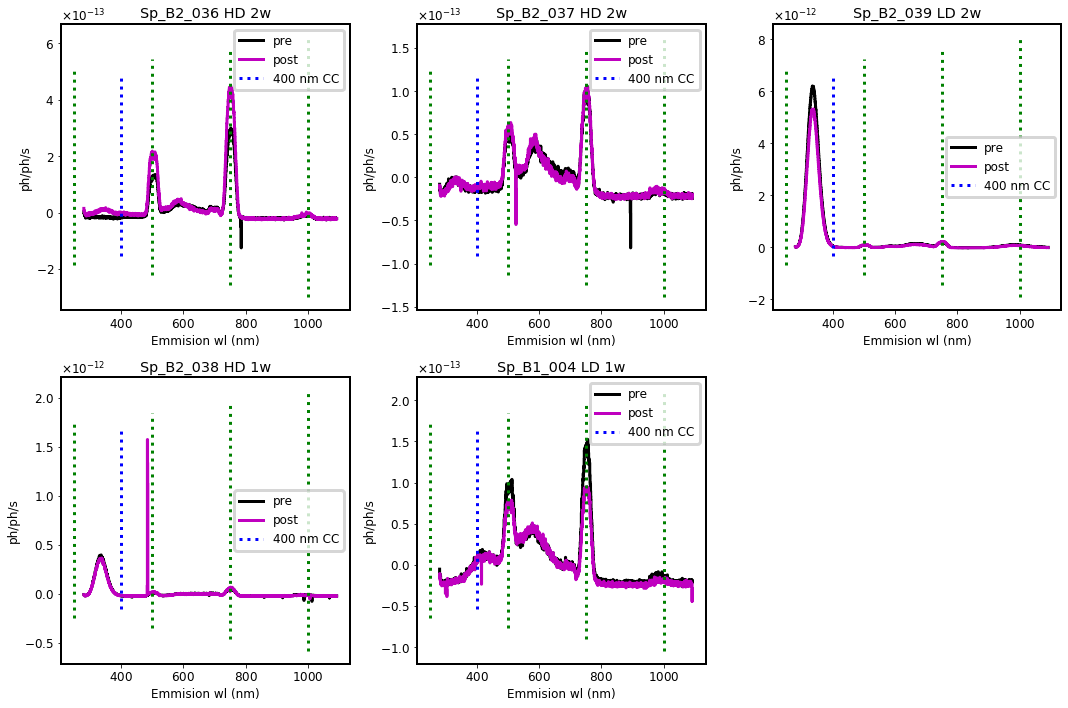

In [10]:
plot_pre_post("Sp", 250)
plot_diff    ("Sp", 250)

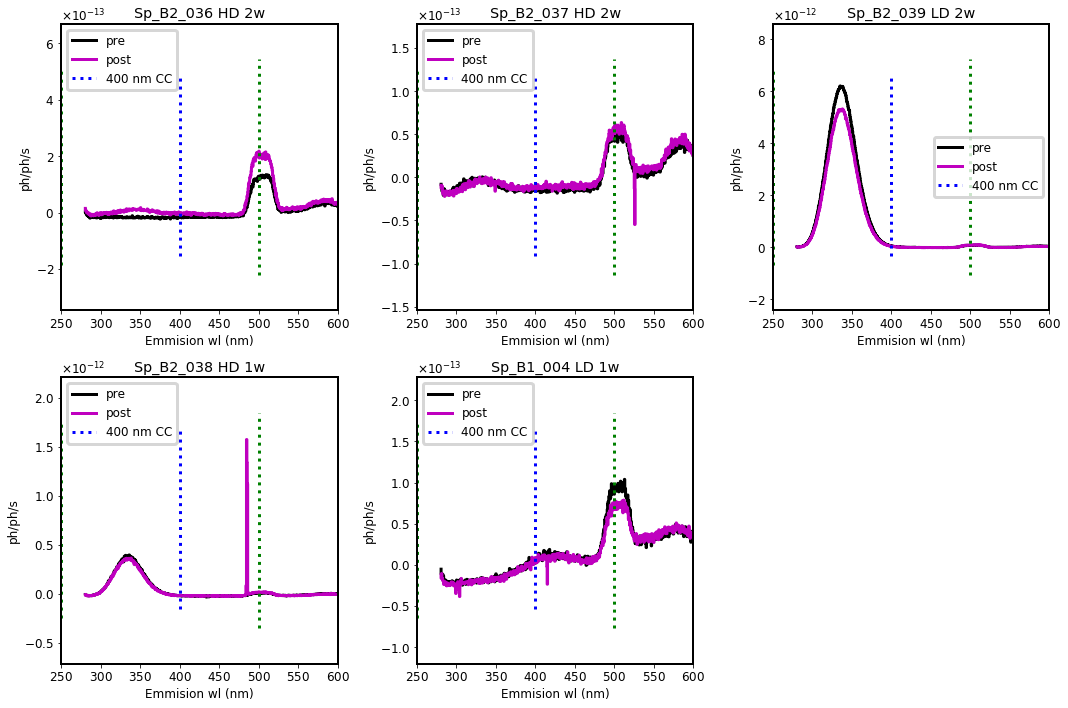

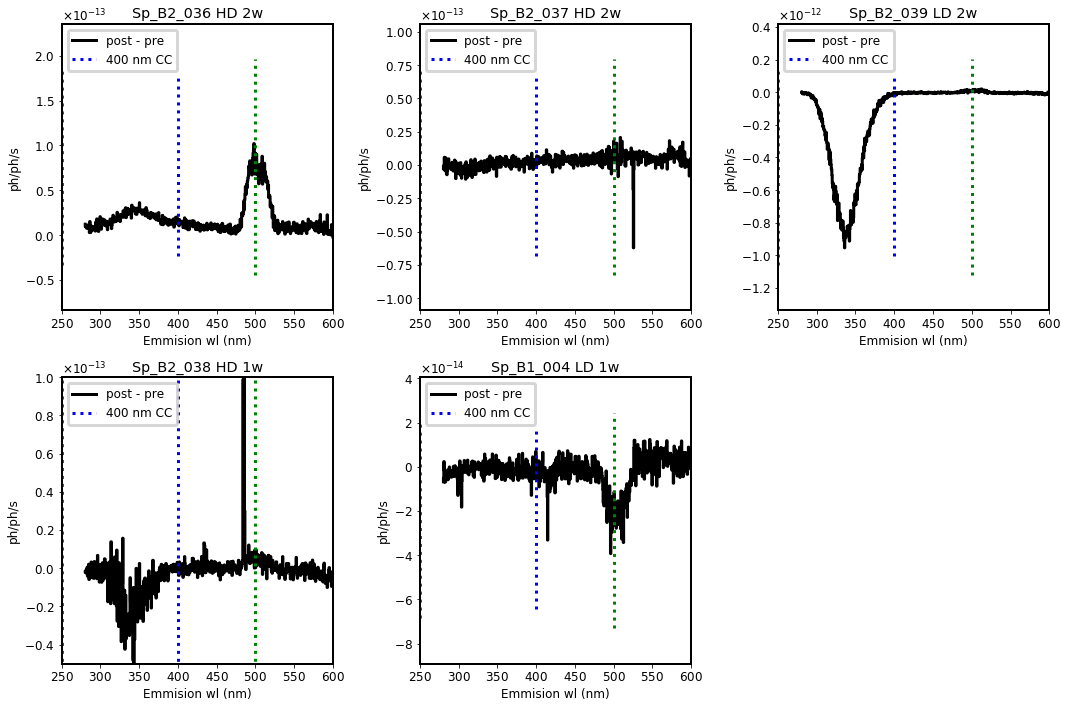

In [11]:
plot_pre_post("Sp", 250, xrange=(250, 600))
plot_diff    ("Sp", 250, xrange=(250, 600))

# Qz

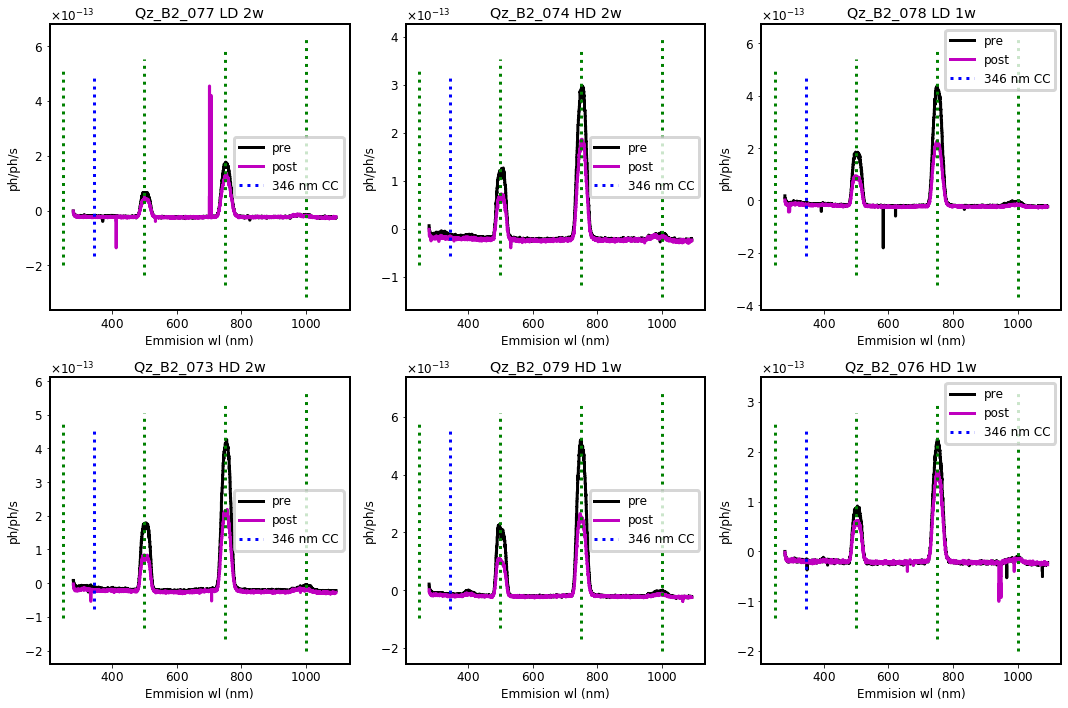

In [12]:
plot_pre_post("Qz", 250)
plot_diff    ("Qz", 250)

# CaF

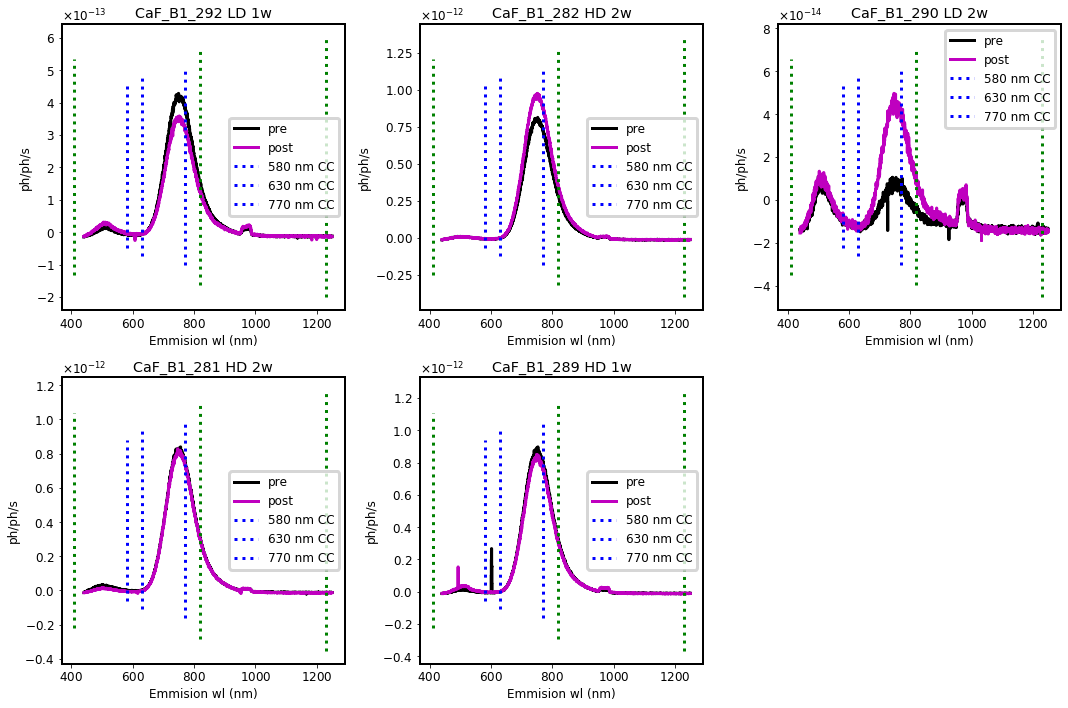

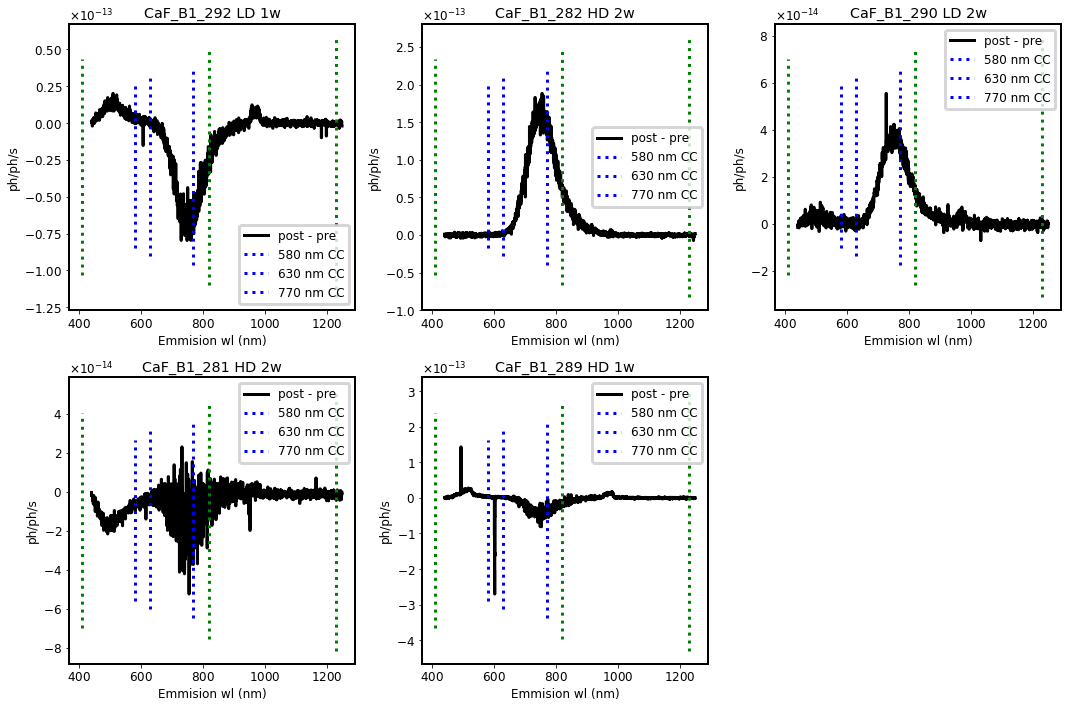

In [13]:
plot_pre_post("CaF", 410)
plot_diff    ("CaF", 410)

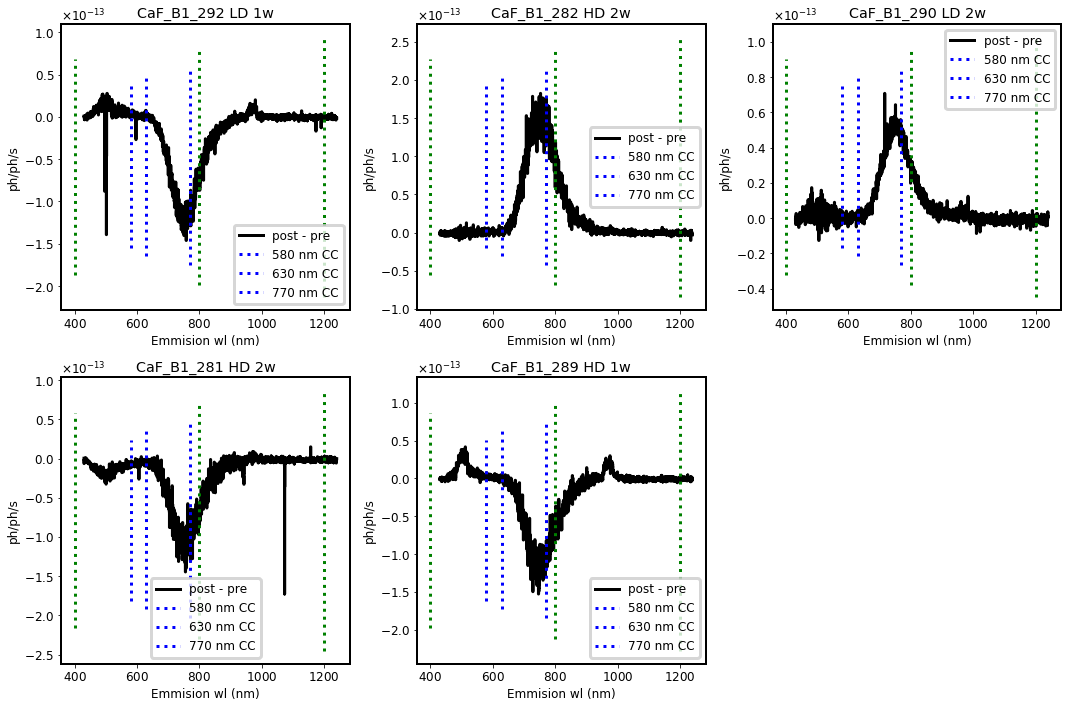

In [14]:
plot_pre_post("CaF", 400)
plot_diff    ("CaF", 400)

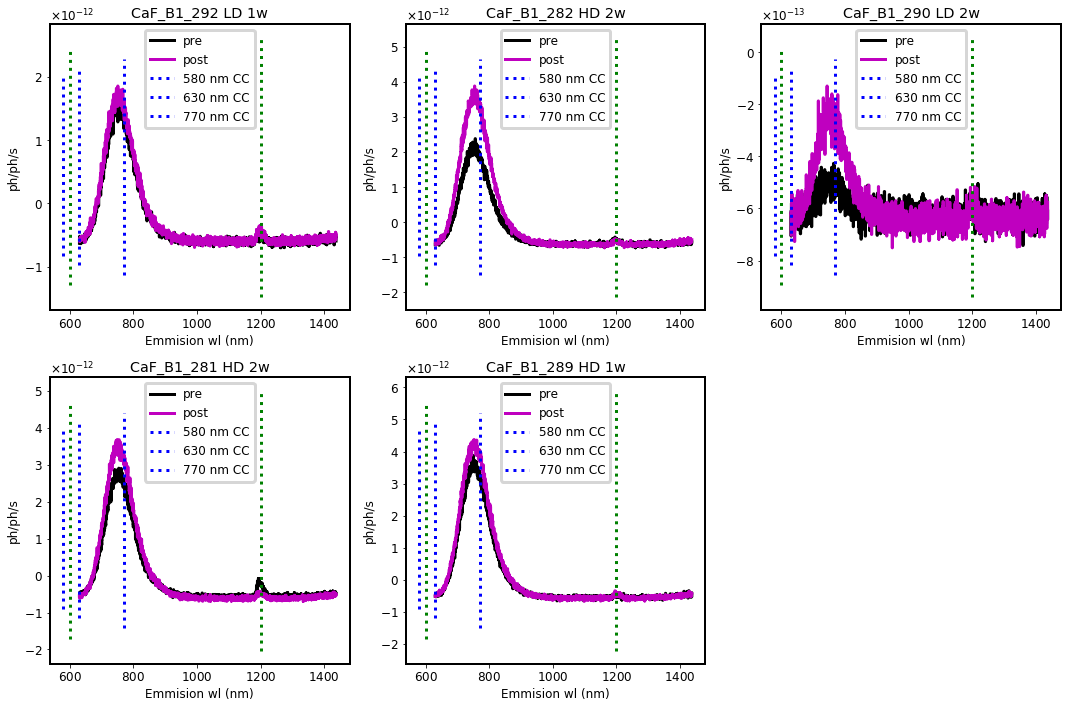

In [15]:
plot_pre_post("CaF", 600, exposure=.1)
plot_diff    ("CaF", 600, exposure=.1)

In [16]:
plot_pre_post("CaF", 350)
plot_diff    ("CaF", 350)

# BaF

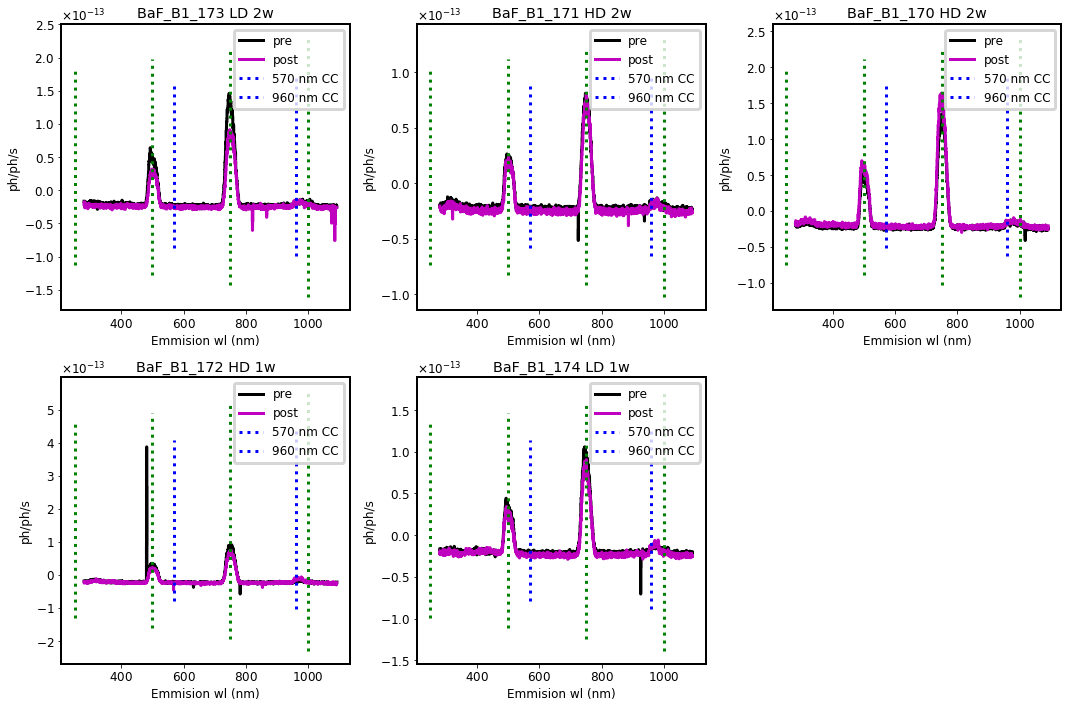

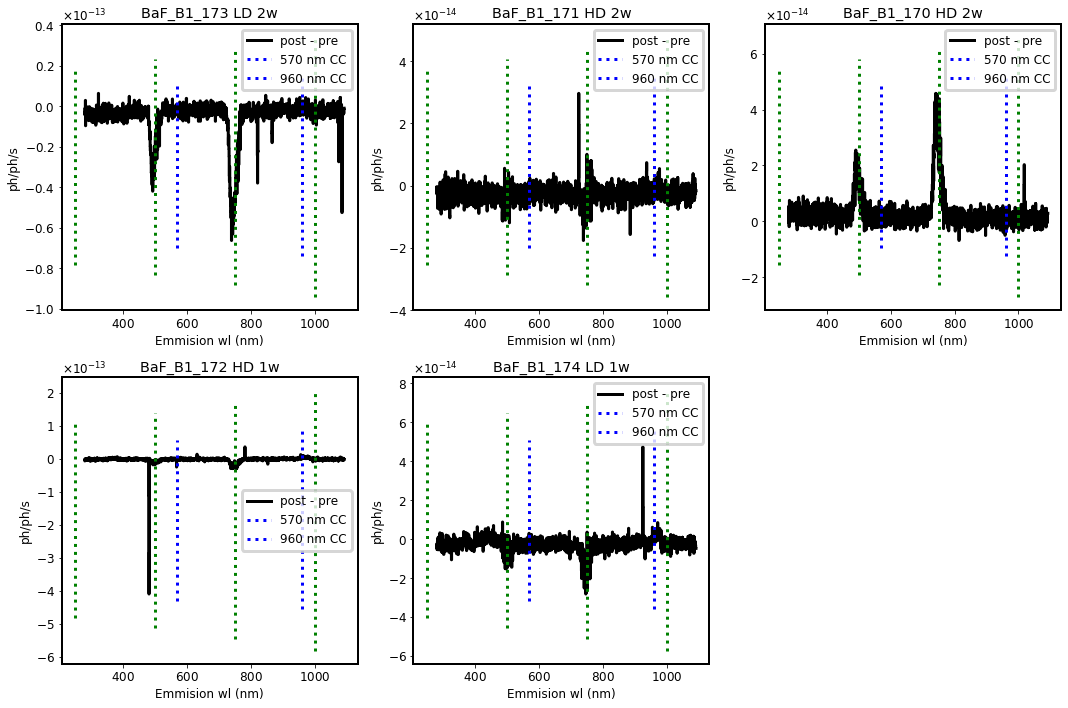

In [17]:
plot_pre_post("BaF", 250)
plot_diff    ("BaF", 250)

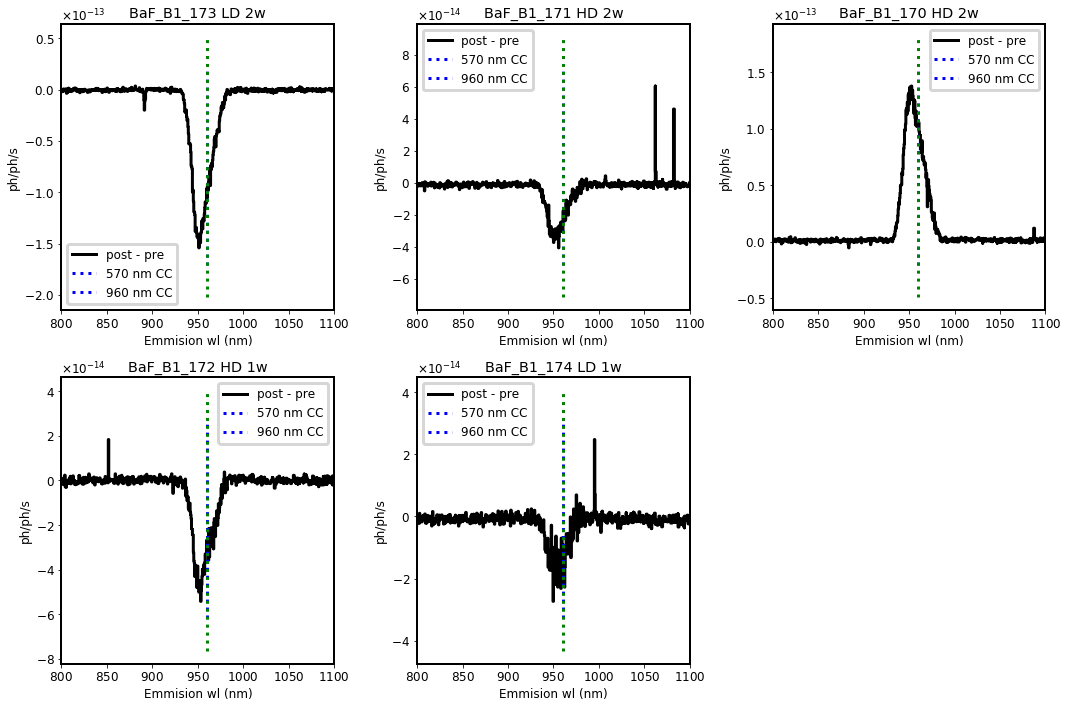

In [18]:
plot_pre_post("BaF", 320, xrange=(800, 1100))
plot_diff    ("BaF", 320, xrange=(800, 1100))

# References

In [19]:
for when in "pre post".split():
    rdf = getattr(experiment, when).references
    rdf = filter_df(rdf, crystal=0, exposure=10)

    for k, (wheel_no, df) in enumerate(rdf.groupby("wheel_no"), start=1):
        plot1d(df.em_wl.values, df.dquanta.values, label=when + " " + str(wheel_no))
    plt.legend()

In [20]:
for when in "pre post".split():
    rdf = getattr(experiment, when).references
    rdf = filter_df(rdf, crystal=3, exposure=1)

    for k, (wheel_no, df) in enumerate(rdf.groupby("wheel_no"), start=1):
        plot1d(df.em_wl.values, df.dquanta.values, label=when + " " + str(wheel_no))
    plt.legend()

In [21]:
%config IPCompleter.greedy=True

In [22]:
%config Completer.use_jedi = False